In [1]:
import matplotlib.pyplot as plot
import warnings
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
from datetime import datetime, date
plt.rcParams.update({'font.size': 16})
from statsmodels.tsa.stattools import adfuller
import requests
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display, Markdown, Latex
from sklearn.metrics import mean_absolute_error
import itertools
import pyodbc
pd.set_option("max_rows", None)

In [2]:
# connect to SQL (1st step)

# establish an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
'Server=DESKTOP-1VJ4H95;'
'Database=AdventureWorks2012;'
'Trusted_Connection=yes;')


In [3]:
# now that the database is connected to python pull the data needed (2nd step)

# pull orderdate Region and revenue  from SQL (AdventureWorks Database)
# plug your SQL query inside the """ """
pythonSQLobject=pd.read_sql_query("""
  SELECT
	--DATEPART(QQ,SSOH.OrderDate) AS  Year_QUARTER
	(SSOH.OrderDate) AS OrderDate
	,SUM((SSOD.UnitPrice-SSOD.UnitPriceDiscount)*(SSOD.OrderQty))AS Revenue
	
	,SST.Name AS Region
    from [Sales].[SalesOrderDetail] AS SSOD
	LEFT JOIN [Sales].[SalesOrderHeader] AS SSOH 
	ON SSOH.SalesOrderID = SSOD.SalesOrderID
	LEFT JOIN [Sales].[SalesTerritory] AS SST
	ON SSOH.TerritoryID = SST.TerritoryID 
	WHERE SST.Name = 'AUSTRALIA' and SSOH.OnlineOrderFlag =1
	GROUP BY (SSOH.OrderDate),SST.Name 
""", conn)

conn.close() # please close it after 


In [4]:
pythonSQLobject.head() # have a look at the data

,OrderDate,Revenue,Region
0,2011-06-27,7652.3582,Australia
1,2011-09-06,3578.2700,Australia
2,2012-08-03,6806.4750,Australia
3,2013-04-21,6279.7589,Australia
4,2014-03-19,5382.0700,Australia


In [5]:
#pythonSQLobject=pythonSQLobject.groupby('OrderDate') # dimensions
#pythonSQLobject = pythonSQLobject.groupby('OrderDate')['Revenue'].sum().reset_index()

In [6]:
pythonSQLobject['OrderDate'].min(), pythonSQLobject['OrderDate'].max()

(Timestamp('2011-05-31 00:00:00'), Timestamp('2014-06-30 00:00:00'))

In [7]:
# now let us extract the order date and revenue
df_New=pythonSQLobject[["OrderDate","Revenue"]].reset_index()

In [8]:
df_New.head(2)

,index,OrderDate,Revenue
0,0,2011-06-27,7652.3582
1,1,2011-09-06,3578.2700


In [9]:
#set index to start fro Orderdate and have a look at it
df_New = df_New.set_index('OrderDate')
df_New.head(2)

,index,Revenue
OrderDate,,
2011-06-27,0,7652.3582
2011-09-06,1,3578.2700


In [10]:
df_New.shape

(1058, 2)

In [11]:
df_New.isnull().sum()

index      0
Revenue    0
dtype: int64

In [12]:
#df_New=df_summary[["OrderDate","Revenue"]]

In [13]:
#df_New=df_New.set_index("OrderDate")
df_New = df_New['Revenue'].resample('MS').mean()


In [14]:
df_New

OrderDate
2011-05-01     3399.990000
2011-06-01     7638.996837
2011-07-01     7673.734110
2011-08-01     7391.395950
2011-09-01     8583.735712
2011-10-01     7504.718028
2011-11-01     9897.492059
2011-12-01     8581.119515
2012-01-01     7037.863978
2012-02-01     8440.044040
2012-03-01     8578.059296
2012-04-01     7327.145830
2012-05-01     7658.296154
2012-06-01     4526.313004
2012-07-01     5394.157885
2012-08-01     5058.932885
2012-09-01     6830.792323
2012-10-01     4266.105969
2012-11-01     6576.422230
2012-12-01     6134.310306
2013-01-01     7177.861932
2013-02-01     6581.039263
2013-03-01     7189.595057
2013-04-01     6838.871063
2013-05-01     6753.130750
2013-06-01     8474.067586
2013-07-01     6129.019677
2013-08-01    10949.811935
2013-09-01    11096.151333
2013-10-01    11462.072581
2013-11-01    12138.439333
2013-12-01    12649.957742
2014-01-01    14033.074839
2014-02-01    12684.657857
2014-03-01    15116.696129
2014-04-01    13770.552667
2014-05-01    1547

In [15]:
df_New.shape

(38,)

In [16]:
df_New.tail()

OrderDate
2014-02-01    12684.657857
2014-03-01    15116.696129
2014-04-01    13770.552667
2014-05-01    15476.342258
2014-06-01      300.416667
Freq: MS, Name: Revenue, dtype: float64

In [17]:
#  2014 Revenue data.

df_New['2014':]

OrderDate
2014-01-01    14033.074839
2014-02-01    12684.657857
2014-03-01    15116.696129
2014-04-01    13770.552667
2014-05-01    15476.342258
2014-06-01      300.416667
Freq: MS, Name: Revenue, dtype: float64

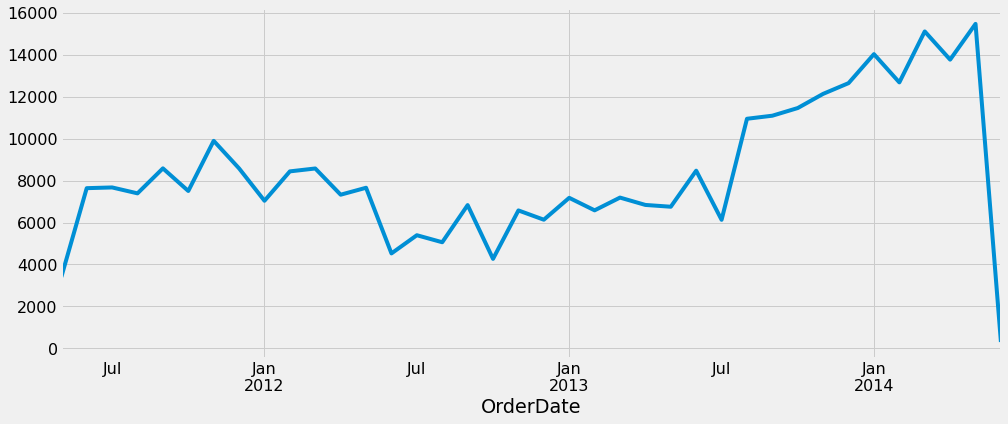

In [18]:
df_New.plot(figsize=(15, 6))
plt.show()

Text(0.5, 1.0, 'Revenue for the Australia Region')

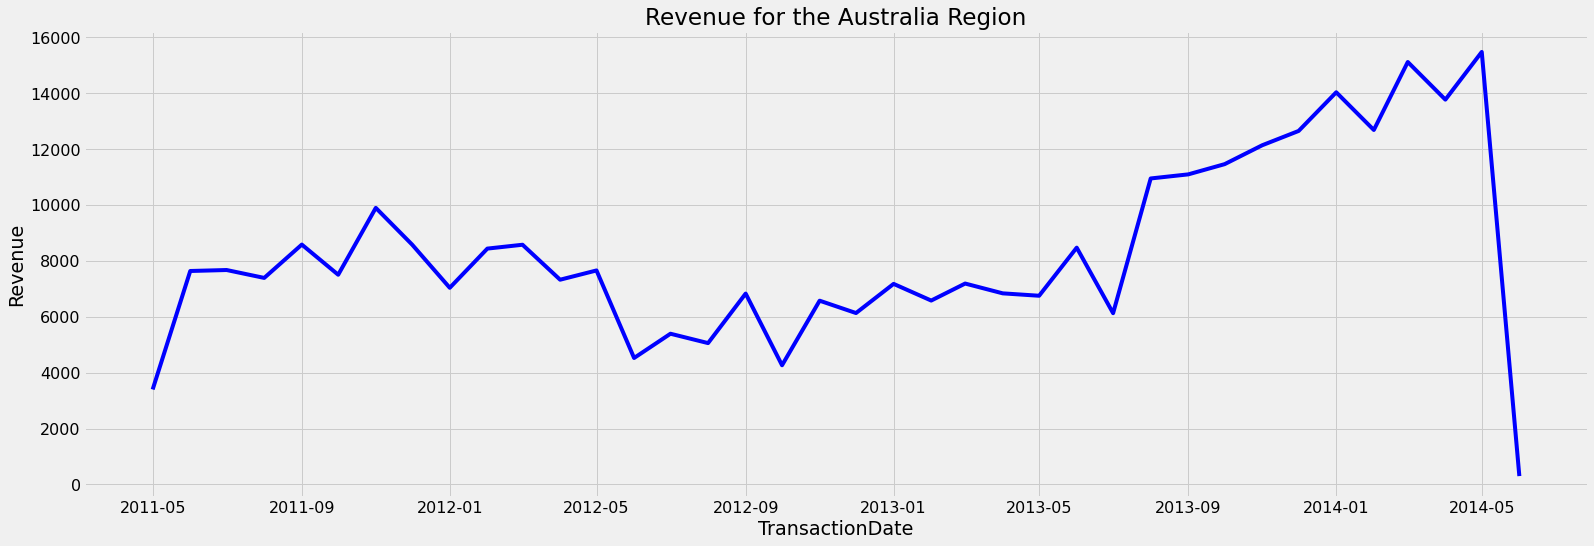

In [19]:


plt.figure(figsize=(24,8))
#tick_locations=[value for value in np.arange(40)]
#plt.xticks(tick_locations, rotation=45)
#plt.figure(figsize=(24, 8))
plt.plot(df_New,'b-')

plt.xlabel('TransactionDate'); plt.ylabel('Revenue'); plt.title('Revenue for the Australia Region')
#plt.show();

### STATIONARIZE TIME SERIES


#### HERE WE ARE GOING TO USE TWO METHOD TO TEST FOR STATIONARITY OF OUR TIME SERIES DATA
#### OUR DATA MUST HAVE CONSTANT MEAN AND STANDARD DEVIATION IRESPECTIVE OF THE TIME OR SEASON IN ORDER TO  HAVE AN ACCURATE PREDICTION

### Dicker Fuller Test
##### It is clearly evident that there is an overall ZIG SAG trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the Dicker Fuller Test.

###### This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the df_summary is non-stationary. The test results comprise of a Test Statistic and some Critical Values for different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis  then accept alternate hypothesis and then say that the series is stationary

In [20]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     ts_log.rolling(12).mean()
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(24,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    #tick_locations=[value for value in np.arange(33)]
    #plt.xticks(tick_locations, rotation=45)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print()
    if dfoutput[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and it is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")    
    

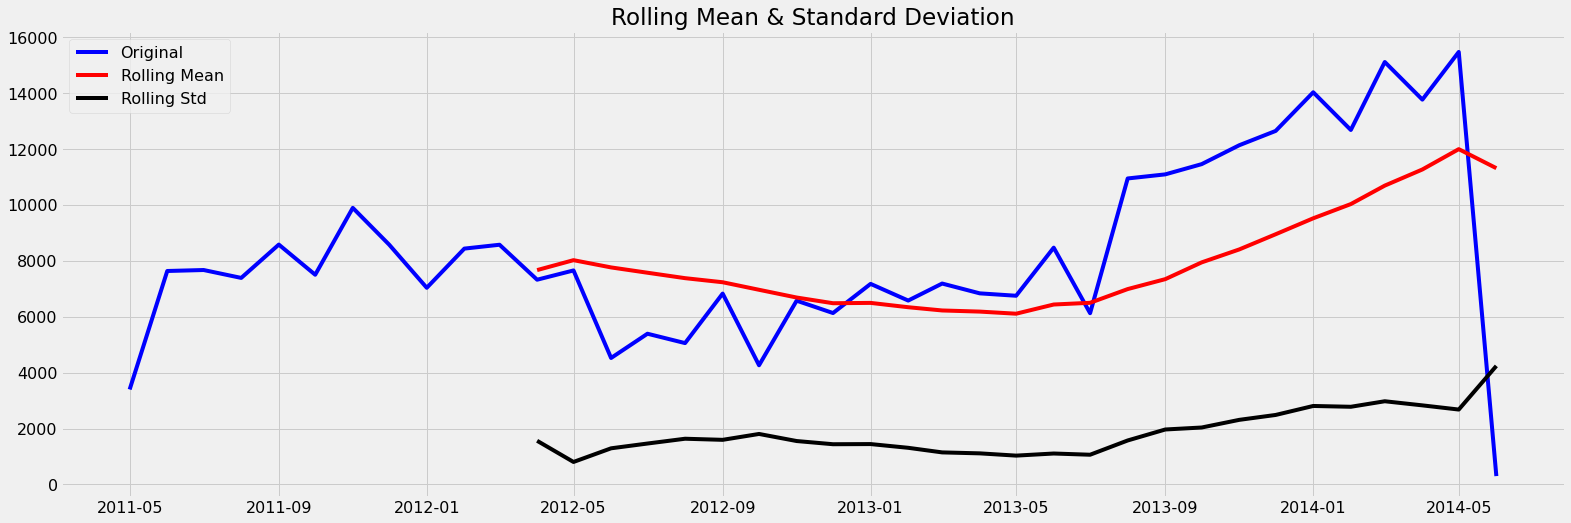

Results of Dickey-Fuller Test:
Test Statistic                 -1.788806
p-value                         0.386033
#Lags Used                      2.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64

weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [21]:
plt.rcParams.update({'font.size': 16})
test_stationarity(df_New)



#### from the rolling mean we can see that the standard deviation and the mean value acrross different dates are constant but this is not enough we need to test for stationary using  augumented dick fuller test
#### Since p <0.05 and test statistic < critical values, we reject Null hypothesis which states that it is non stationary and accept the alternate hypothesis 

### The ARIMA Time Series Model

#### We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, 

#### we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. 

#### Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let’s begin by generating the various combination of parameters that we wish to assess:



#### We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

#### ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [22]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [23]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_New,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:781.3881039989428
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1092.0965829668696
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:497.3683261823868
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:271.99673467253467
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:517.6437846393128
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:832.8395301488508
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:277.27505357803324
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:249.7771351000627
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:736.0041389512976
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:478.6169967820586
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:247.52616596796452
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:513.2540209439264
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2722.0377333433685
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:273.29783879235816
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:231.88695038765104
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:680.319566279957
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 -

### The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 238.71 Therefore we should consider this to be optimal option.

## Fitting the ARIMA model

In [24]:
mod = sm.tsa.statespace.SARIMAX(df_New,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])








                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1042      0.538     -0.194      0.846      -1.158       0.950
ma.L1         -1.0042      2.424     -0.414      0.679      -5.756       3.747
ar.S.L12      -1.8421      0.520     -3.540      0.000      -2.862      -0.822
ma.S.L12       1.2853      2.233      0.576      0.565      -3.090       5.661
sigma2      2.545e+06   6.09e-07   4.18e+12      0.000    2.55e+06    2.55e+06


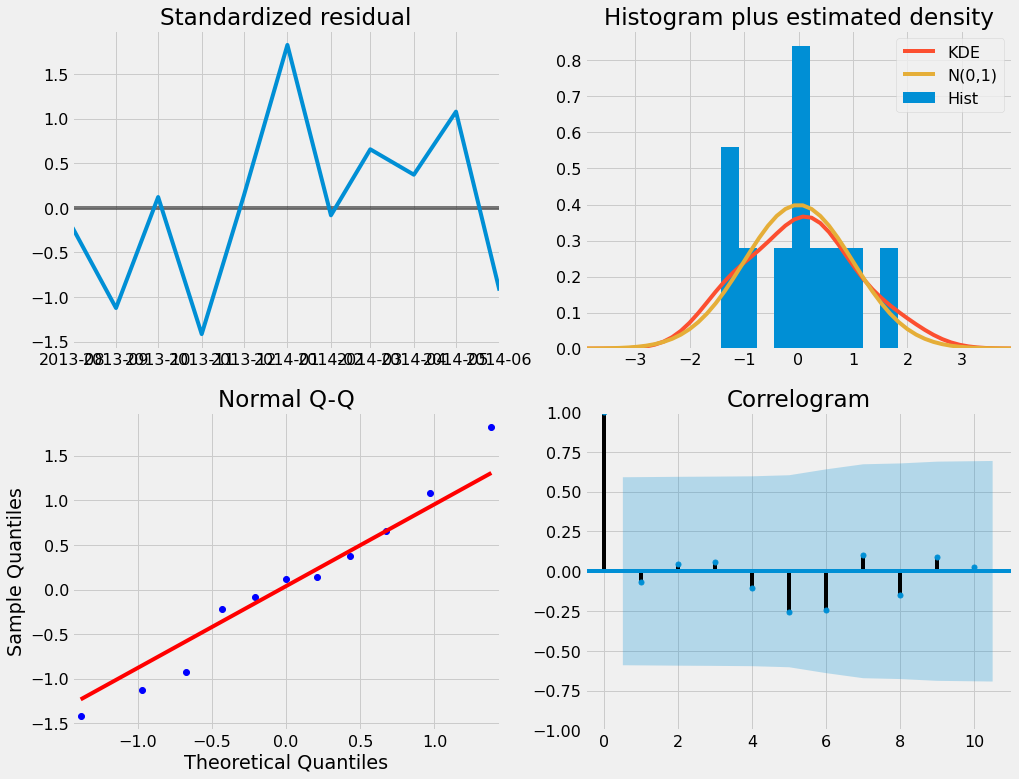

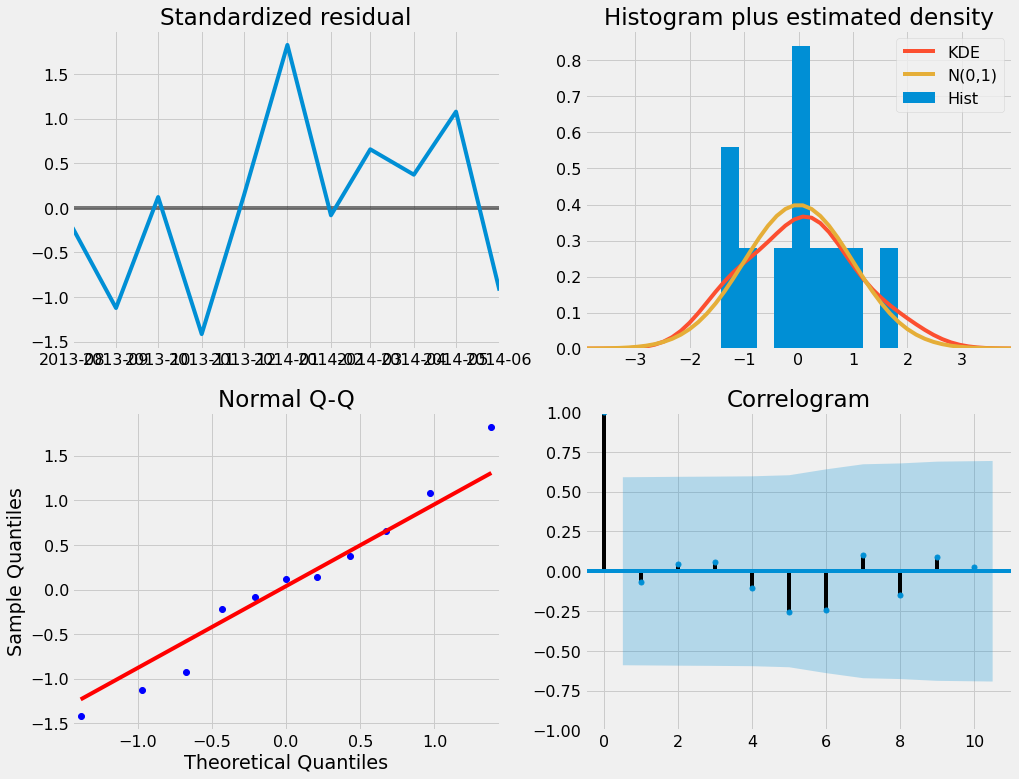

In [25]:
# The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(15, 12))


## Validating Forecasts

#### The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

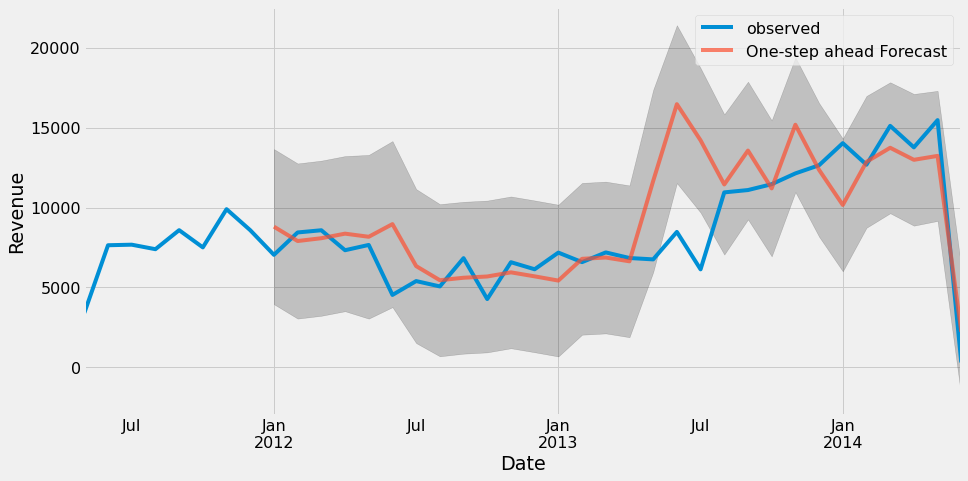

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2012-01-01 '), dynamic=False)
pred_ci = pred.conf_int()

ax = df_New['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()

#plt.show()

#### it is always better to quantify the accuracy of our forecasts. We will use mean of residuals and the MSE (Mean Squared Error), which summarizes the average error

In [27]:
y_forecasted = pred.predicted_mean
y_truth = df_New['2011-05-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
residual_mean=np.mean(y_forecasted - y_truth)

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('The mean of residuals is {}'.format(round(residual_mean, 2)))

The Root Mean Squared Error of our forecasts is 2759.74
The mean of residuals is 845.38


In [28]:
# print(y_forecasted)

#### Clearly with such statistical measures, we cannot accept that

In [29]:
#df_New_prophet = df_New.rename(column={'OrderDate': 'ds', 'Revenue': 'y'})
#df_New_prophet.head(2)

df_New_prophet=df_New.reset_index(level="OrderDate")
# ts_df_prophet
df_New_prophet.columns=['ds','y']
df_New_prophet.head(2)

,ds,y
0,2011-05-01,3399.990000
1,2011-06-01,7638.996837


In [30]:
from fbprophet import Prophet
#prophet reqiures a pandas df

model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(df_New_prophet) 

# predict for 60 which represnt five years months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 60, freq = 'MS') 

# now lets make the forecasts
forecast_prophet = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
forecast_prophet.tail(20)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
78,2017-11-01,15811.043592,13351.802335,20280.960552,15810.843249,15811.252638,1173.674772,1173.674772,1173.674772,1173.674772,1173.674772,1173.674772,0.0,0.0,0.0,16984.718364
79,2017-12-01,15934.843504,13393.073234,20069.267257,15934.637636,15935.060819,711.517524,711.517524,711.517524,711.517524,711.517524,711.517524,0.0,0.0,0.0,16646.361028
80,2018-01-01,16062.770081,13941.116670,20434.088052,16062.555992,16062.993311,1118.556877,1118.556877,1118.556877,1118.556877,1118.556877,1118.556877,0.0,0.0,0.0,17181.326959
81,2018-02-01,16190.696658,13599.570491,19945.335252,16190.475189,16190.925691,526.480707,526.480707,526.480707,526.480707,526.480707,526.480707,0.0,0.0,0.0,16717.177365
82,2018-03-01,16306.243243,14808.638643,21285.693266,16306.016047,16306.479623,1829.116929,1829.116929,1829.116929,1829.116929,1829.116929,1829.116929,0.0,0.0,0.0,18135.360173
83,2018-04-01,16434.169820,14176.684895,20418.318282,16433.934179,16434.414834,879.505210,879.505210,879.505210,879.505210,879.505210,879.505210,0.0,0.0,0.0,17313.675030
84,2018-05-01,16557.969733,12639.386761,19631.788266,16557.726933,16558.223072,-276.741376,-276.741376,-276.741376,-276.741376,-276.741376,-276.741376,0.0,0.0,0.0,16281.228357
85,2018-06-01,16685.896310,10151.553307,16682.847396,16685.645397,16686.158153,-3313.935419,-3313.935419,-3313.935419,-3313.935419,-3313.935419,-3313.935419,0.0,0.0,0.0,13371.960891
86,2018-07-01,16809.696223,12800.885522,19018.325067,16809.436182,16809.966173,-1038.936449,-1038.936449,-1038.936449,-1038.936449,-1038.936449,-1038.936449,0.0,0.0,0.0,15770.759773
87,2018-08-01,16937.622799,13632.975859,20132.202687,16937.355638,16937.903369,-72.044844,-72.044844,-72.044844,-72.044844,-72.044844,-72.044844,0.0,0.0,0.0,16865.577956


In [32]:
forecast_prophet=forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# model.plot(forecast)
forecast_prophet.head(2)

,ds,yhat,yhat_lower,yhat_upper
0,2011-05-01,5049.343275,1602.094257,8047.151753
1,2011-06-01,2543.699034,-640.637945,5872.306672


In [33]:
pred_prophet = np.asarray(forecast_prophet['yhat'])
y_truth = df_New['2011':]

In [34]:
forecast_prophet2=forecast_prophet.groupby(['ds']).sum()['yhat']

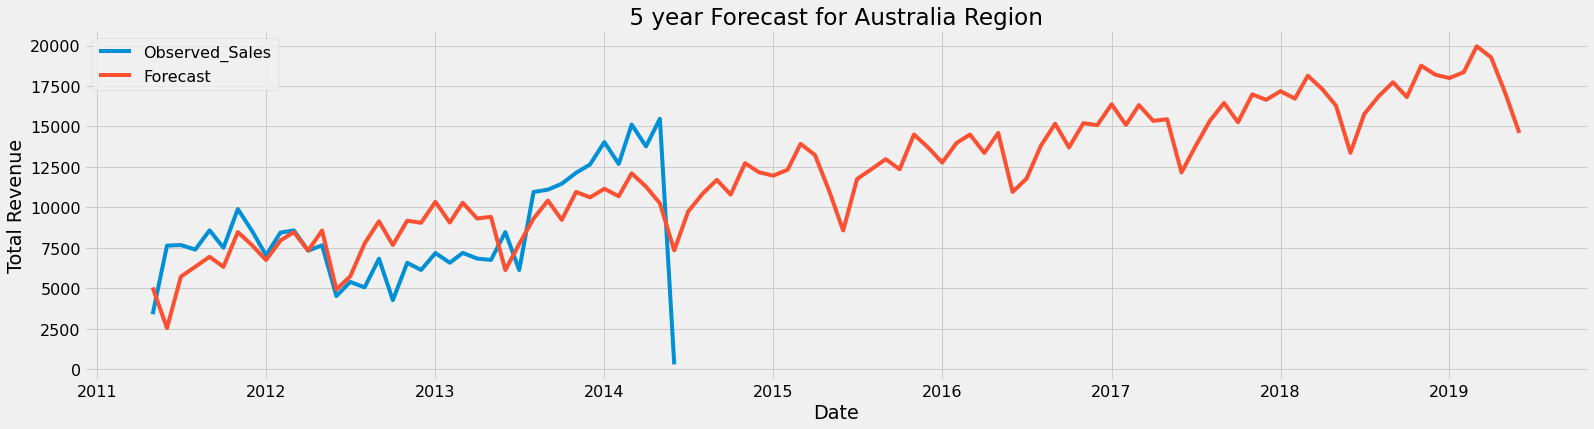

In [35]:
fig, ax = plt.subplots(figsize=(24, 6));
plt.plot(y_truth,label='Observed_Sales',alpha=2)
plt.plot(forecast_prophet2,label='Forecast',alpha=2)




ax.set_xlabel('Date')
ax.set_ylabel('Total Revenue')
plt.legend()
plt.title(" 5 year Forecast for Australia Region ")
plt.show()


In [36]:
myForecast=pd.DataFrame({"OrderDate":forecast_prophet['ds'],"Observed_Sales":pd.Series(y_truth.values).round(1),
              "Projected_Sales":(forecast_prophet['yhat']).round(1)
             })
myForecast.head()

,OrderDate,Observed_Sales,Projected_Sales
0,2011-05-01,3400.0,5049.3
1,2011-06-01,7639.0,2543.7
2,2011-07-01,7673.7,5722.7
3,2011-08-01,7391.4,6330.4
4,2011-09-01,8583.7,6950.4


In [37]:
myForecast.head()

,OrderDate,Observed_Sales,Projected_Sales
0,2011-05-01,3400.0,5049.3
1,2011-06-01,7639.0,2543.7
2,2011-07-01,7673.7,5722.7
3,2011-08-01,7391.4,6330.4
4,2011-09-01,8583.7,6950.4


In [85]:
myForecast.to_csv("my5YearsSalesForecast.csv")

In [47]:
# now let me convert the order date to quarter as requested.
import datetime as dt

In [36]:
y=pd.DataFrame({"Date":forecast_prophet['ds'].dt.year,"Date_In_Quarter":forecast_prophet['ds'].dt.quarter,"Observed":pd.Series(y_truth.values).round(1),
              "Predicted":(forecast_prophet['yhat']).round(1), "YOY_Percent":(((forecast_prophet['yhat']).round(1))/(pd.Series(y_truth.values).round(1)))*100
             })
y.head()

,Date,Date_In_Quarter,Observed,Predicted,YOY_Percent
0,2011,2,3400.0,5049.3,148.508824
1,2011,2,7639.0,2543.7,33.298861
2,2011,3,7673.7,5722.7,74.575498
3,2011,3,7391.4,6330.4,85.645480
4,2011,3,8583.7,6950.4,80.972075


In [40]:
# top 10 pridicted value
y_sorted = y.sort_values("Predicted",ascending=False)

In [41]:
y_sorted

,Date,Date_In_Quarter,Observed,Predicted,YOY_Percent
94,2019,1,NaN,19953.6,NaN
95,2019,2,NaN,19266.8,NaN
90,2018,4,NaN,18760.9,NaN
93,2019,1,NaN,18355.9,NaN
91,2018,4,NaN,18201.3,NaN
82,2018,1,NaN,18135.4,NaN
92,2019,1,NaN,17990.2,NaN
88,2018,3,NaN,17730.4,NaN
83,2018,2,NaN,17313.7,NaN
80,2018,1,NaN,17181.3,NaN


In [39]:
y_sorted.shape

(10, 5)

In [44]:

#top100 = df_summary.head(100) 
y.to_csv("5YearsSalesForecast.csv")

In [45]:
pwd

'C:\\Users\\Oluseye\\Documents'